In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
from datetime import datetime
import joblib
import json
import warnings
warnings.filterwarnings('ignore')
import os
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

In [36]:
# Configuración de tipos de datos
dtype_mapping = {
    'Fecha': 'datetime64[ns]',
    'Ubicacion': 'category',
    'TempMin': 'float64',
    'TempMax': 'float64',
    'Lluvia': 'float64',
    'Evaporacion': 'float64',
    'Sol': 'float64',
    'DirRafaga': 'category',
    'VelRafaga': 'float64',
    'Dir9am': 'category',
    'Dir3pm': 'category',
    'Vel9am': 'float64',
    'Vel3pm': 'float64',
    'Hum9am': 'float64',
    'Hum3pm': 'float64',
    'Pres9am': 'float64',
    'Pres3pm': 'float64',
    'Nub9am': 'float64',
    'Nub3pm': 'float64',
    'Temp9am': 'float64',
    'Temp3pm': 'float64',
    'LluviaHoy': 'category',
    'RISK_MM': 'float64',
    'LluviaMan': 'category'
}

In [37]:
# 1. COMPRENSIÓN DEL NEGOCIO
print("=== 1. COMPRENSIÓN DEL NEGOCIO ===")
print("Objetivo: Analizar patrones climáticos en Australia para predecir lluvia")
print("Contexto: Datos meteorológicos de múltiples ubicaciones australianas")
print("Alcance: Predicción de lluvia basada en variables meteorológicas")


=== 1. COMPRENSIÓN DEL NEGOCIO ===
Objetivo: Analizar patrones climáticos en Australia para predecir lluvia
Contexto: Datos meteorológicos de múltiples ubicaciones australianas
Alcance: Predicción de lluvia basada en variables meteorológicas


In [38]:
# 2. COMPRENSIÓN DE LOS DATOS
print("\n=== 2. COMPRENSIÓN DE LOS DATOS ===")
df = pd.read_parquet('weather_australia.parquet')



=== 2. COMPRENSIÓN DE LOS DATOS ===


In [39]:
# Conversión de tipos de datos
df['Fecha'] = pd.to_datetime(df['Fecha'])
categorical_columns = ['Ubicacion', 'DirRafaga', 'Dir9am', 'Dir3pm', 'LluviaHoy', 'LluviaMan']
for col in categorical_columns:
    df[col] = df[col].astype('category')

numeric_columns = [col for col, dtype in dtype_mapping.items() if dtype == 'float64']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nInformación detallada del dataset:")
print(f"Total de registros: {len(df):,}")
print(f"Período de tiempo: {df['Fecha'].min()} a {df['Fecha'].max()}")
print(f"Número de ubicaciones: {df['Ubicacion'].nunique()}")
print("\nTipos de datos después de la conversión:")
print(df.dtypes)

print("\nEstadísticas descriptivas:")
print(df.describe())


Información detallada del dataset:
Total de registros: 142,193
Período de tiempo: 2007-11-01 00:00:00 a 2017-06-25 00:00:00
Número de ubicaciones: 49

Tipos de datos después de la conversión:
Fecha          datetime64[ns]
Ubicacion            category
TempMin               float64
TempMax               float64
Lluvia                float64
Evaporacion           float64
Sol                   float64
DirRafaga            category
VelRafaga             float64
Dir9am               category
Dir3pm               category
Vel9am                float64
Vel3pm                float64
Hum9am                float64
Hum3pm                float64
Pres9am               float64
Pres3pm               float64
Nub9am                float64
Nub3pm                float64
Temp9am               float64
Temp3pm               float64
LluviaHoy            category
RISK_MM               float64
LluviaMan            category
dtype: object

Estadísticas descriptivas:
                               Fecha        T

In [40]:
# 3. PREPARACIÓN DE DATOS
print("\n=== 3. PREPARACIÓN DE DATOS ===")
print("Análisis de valores nulos:")
for columna in df.columns:
    nulos = df[columna].isnull().sum()
    porcentaje = (nulos/len(df))*100
    print(f"{columna}: {nulos:,} valores nulos ({porcentaje:.2f}%)")


=== 3. PREPARACIÓN DE DATOS ===
Análisis de valores nulos:
Fecha: 0 valores nulos (0.00%)
Ubicacion: 0 valores nulos (0.00%)
TempMin: 637 valores nulos (0.45%)
TempMax: 322 valores nulos (0.23%)
Lluvia: 1,406 valores nulos (0.99%)
Evaporacion: 60,843 valores nulos (42.79%)
Sol: 67,816 valores nulos (47.69%)
DirRafaga: 9,330 valores nulos (6.56%)
VelRafaga: 9,270 valores nulos (6.52%)
Dir9am: 10,013 valores nulos (7.04%)
Dir3pm: 3,778 valores nulos (2.66%)
Vel9am: 1,348 valores nulos (0.95%)
Vel3pm: 2,630 valores nulos (1.85%)
Hum9am: 1,774 valores nulos (1.25%)
Hum3pm: 3,610 valores nulos (2.54%)
Pres9am: 14,014 valores nulos (9.86%)
Pres3pm: 13,981 valores nulos (9.83%)
Nub9am: 53,657 valores nulos (37.74%)
Nub3pm: 57,094 valores nulos (40.15%)
Temp9am: 904 valores nulos (0.64%)
Temp3pm: 2,726 valores nulos (1.92%)
LluviaHoy: 1,406 valores nulos (0.99%)
RISK_MM: 0 valores nulos (0.00%)
LluviaMan: 0 valores nulos (0.00%)


In [41]:
# Tratamiento de valores nulos
columnas_numericas = df.select_dtypes(include=[np.number]).columns
for col in columnas_numericas:
    df[col] = df[col].fillna(df[col].mean())

print("\nValores nulos después de limpieza:")
print(df.isnull().sum())


Valores nulos después de limpieza:
Fecha              0
Ubicacion          0
TempMin            0
TempMax            0
Lluvia             0
Evaporacion        0
Sol                0
DirRafaga       9330
VelRafaga          0
Dir9am         10013
Dir3pm          3778
Vel9am             0
Vel3pm             0
Hum9am             0
Hum3pm             0
Pres9am            0
Pres3pm            0
Nub9am             0
Nub3pm             0
Temp9am            0
Temp3pm            0
LluviaHoy       1406
RISK_MM            0
LluviaMan          0
dtype: int64


In [42]:
# 4. ANÁLISIS EXPLORATORIO Y MODELADO
print("\n=== 4. ANÁLISIS EXPLORATORIO Y MODELADO ===")

print("\nEstadísticas por ubicación:")
for ubicacion in df['Ubicacion'].unique():
    subset = df[df['Ubicacion'] == ubicacion]
    print(f"\n{ubicacion}:")
    print(f"Temperatura máxima promedio: {subset['TempMax'].mean():.2f}°C")
    print(f"Días con lluvia: {(subset['LluviaMan'] == 'Yes').sum():,}")
    print(f"Porcentaje de días lluviosos: {((subset['LluviaMan'] == 'Yes').sum() / len(subset)) * 100:.2f}%")



=== 4. ANÁLISIS EXPLORATORIO Y MODELADO ===

Estadísticas por ubicación:

Albury:
Temperatura máxima promedio: 22.63°C
Días con lluvia: 618
Porcentaje de días lluviosos: 20.52%

BadgerysCreek:
Temperatura máxima promedio: 24.02°C
Días con lluvia: 583
Porcentaje de días lluviosos: 19.91%

Cobar:
Temperatura máxima promedio: 25.83°C
Días con lluvia: 386
Porcentaje de días lluviosos: 12.92%

CoffsHarbour:
Temperatura máxima promedio: 23.91°C
Días con lluvia: 869
Porcentaje de días lluviosos: 29.43%

Moree:
Temperatura máxima promedio: 26.89°C
Días con lluvia: 394
Porcentaje de días lluviosos: 13.81%



Newcastle:
Temperatura máxima promedio: 24.05°C
Días con lluvia: 731
Porcentaje de días lluviosos: 24.74%

NorahHead:
Temperatura máxima promedio: 22.61°C
Días con lluvia: 808
Porcentaje de días lluviosos: 27.59%

NorfolkIsland:
Temperatura máxima promedio: 21.79°C
Días con lluvia: 919
Porcentaje de días lluviosos: 31.01%

Penrith:
Temperatura máxima promedio: 24.73°C
Días con lluvia: 595
Porcentaje de días lluviosos: 20.07%

Richmond:
Temperatura máxima promedio: 24.45°C
Días con lluvia: 560
Porcentaje de días lluviosos: 18.98%

Sydney:
Temperatura máxima promedio: 23.00°C
Días con lluvia: 865
Porcentaje de días lluviosos: 25.92%

SydneyAirport:
Temperatura máxima promedio: 23.38°C
Días con lluvia: 774
Porcentaje de días lluviosos: 25.76%

WaggaWagga:
Temperatura máxima promedio: 22.96°C
Días con lluvia: 536
Porcentaje de días lluviosos: 18.01%

Williamtown:
Temperatura máxima promedio: 24.15°C
Días con lluvia: 700
Porcentaje de días lluviosos: 27.42%

Wollongong:
Temperatura máxima 

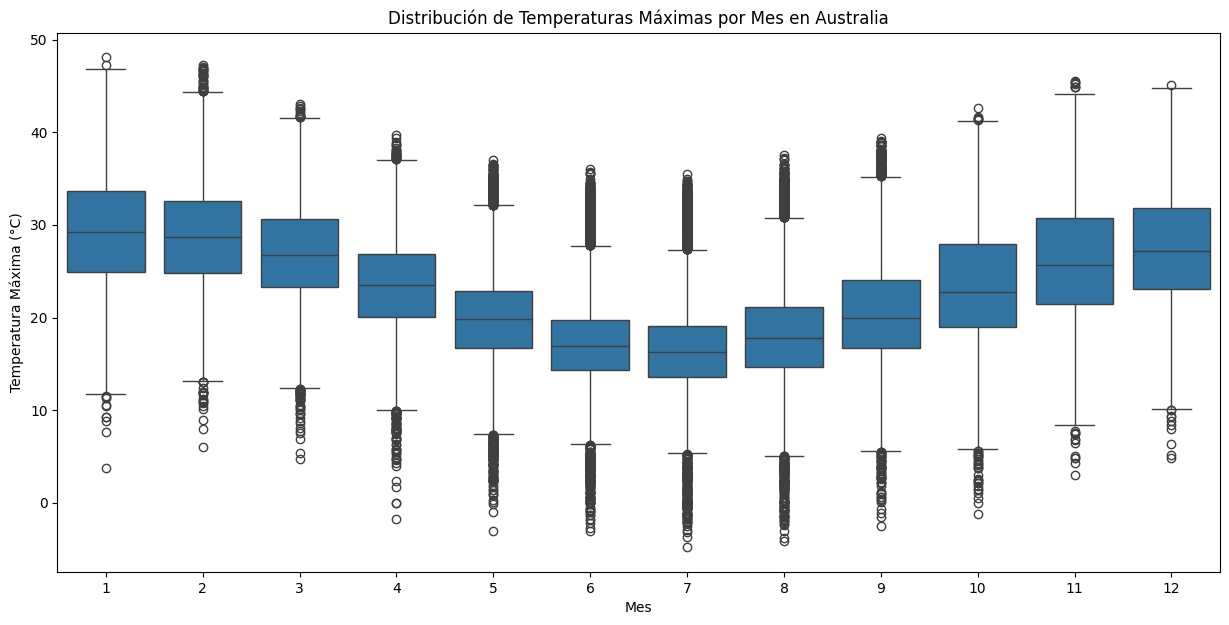

In [43]:
# Visualización 1: Distribución de temperaturas por mes
plt.figure(figsize=(15, 7))
df['Mes'] = df['Fecha'].dt.month
sns.boxplot(data=df, x='Mes', y='TempMax')
plt.title('Distribución de Temperaturas Máximas por Mes en Australia')
plt.xlabel('Mes')
plt.ylabel('Temperatura Máxima (°C)')
plt.show()

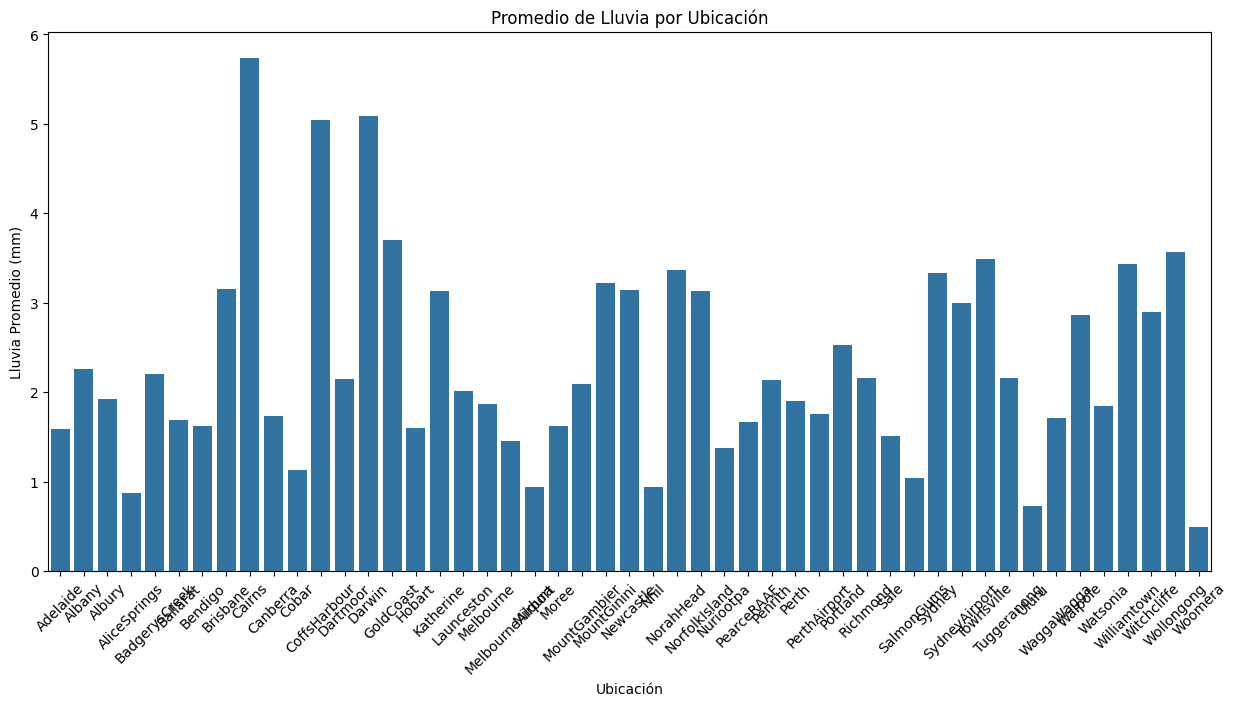

In [44]:
# Visualización 2: Lluvia por ubicación
plt.figure(figsize=(15, 7))
sns.barplot(data=df.groupby('Ubicacion')['Lluvia'].mean().reset_index().sort_values('Lluvia', ascending=False),
            x='Ubicacion', y='Lluvia')
plt.xticks(rotation=45)
plt.title('Promedio de Lluvia por Ubicación')
plt.xlabel('Ubicación')
plt.ylabel('Lluvia Promedio (mm)')
plt.show()

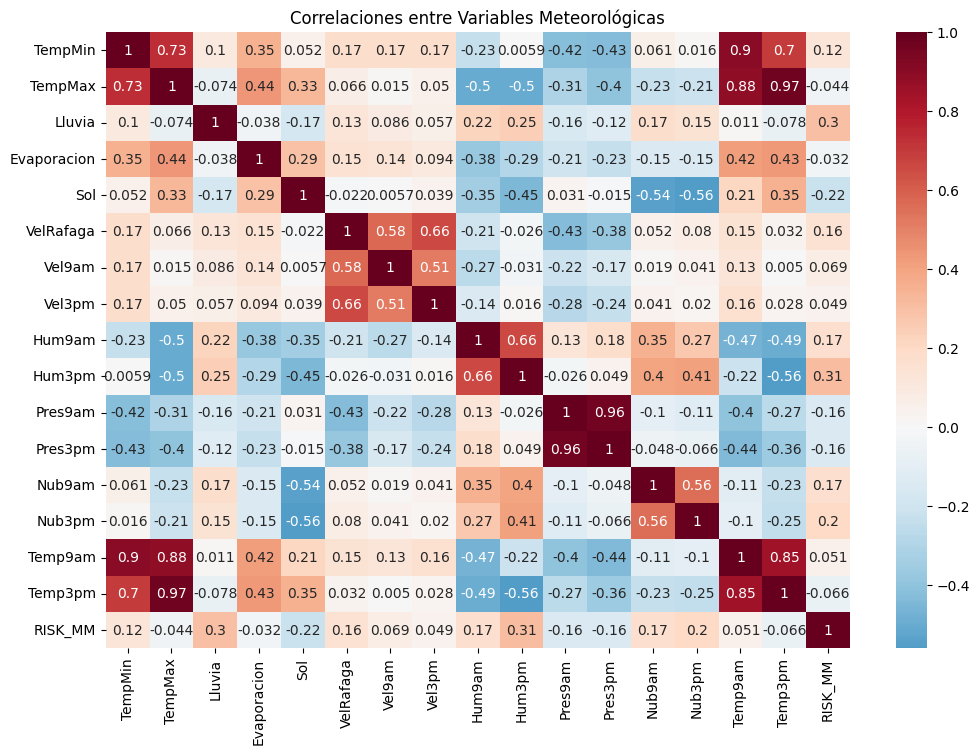

In [45]:
# Visualización 3: Correlaciones
plt.figure(figsize=(12, 8))
sns.heatmap(df[columnas_numericas].corr(), annot=True, cmap='RdBu_r', center=0)
plt.title('Correlaciones entre Variables Meteorológicas')
plt.show()

In [46]:
# Análisis de patrones
print("\nPatrones identificados:")
patrones = {
    "Correlación temperatura-lluvia": df['TempMax'].corr(df['Lluvia']),
    "Promedio de lluvia": df['Lluvia'].mean(),
    "Días con lluvia": (df['LluviaMan'] == 'Yes').sum()
}
for key, value in patrones.items():
    print(f"{key}: {value:.2f}")


Patrones identificados:
Correlación temperatura-lluvia: -0.07
Promedio de lluvia: 2.35
Días con lluvia: 31877.00


In [47]:
# 5. MODELADO PREDICTIVO
print("\n=== 5. MODELADO PREDICTIVO ===")
X = df[['TempMin', 'TempMax', 'Lluvia', 'VelRafaga', 'Hum9am', 'Hum3pm']]
y = (df['LluviaMan'] == 'Yes').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nCaracterísticas del conjunto de entrenamiento:")
print(f"Registros de entrenamiento: {X_train.shape[0]:,}")
print(f"Registros de prueba: {X_test.shape[0]:,}")
print(f"Variables utilizadas: {', '.join(X.columns)}")

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)


=== 5. MODELADO PREDICTIVO ===

Características del conjunto de entrenamiento:
Registros de entrenamiento: 113,754
Registros de prueba: 28,439
Variables utilizadas: TempMin, TempMax, Lluvia, VelRafaga, Hum9am, Hum3pm


RandomForestClassifier(n_estimators=200, random_state=42)

In [48]:
# 6. EVALUACIÓN
print("\n=== 6. EVALUACIÓN DEL MODELO ===")
y_pred = rf_model.predict(X_test_scaled)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


=== 6. EVALUACIÓN DEL MODELO ===

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     22098
           1       0.70      0.47      0.57      6341

    accuracy                           0.84     28439
   macro avg       0.78      0.71      0.73     28439
weighted avg       0.83      0.84      0.83     28439



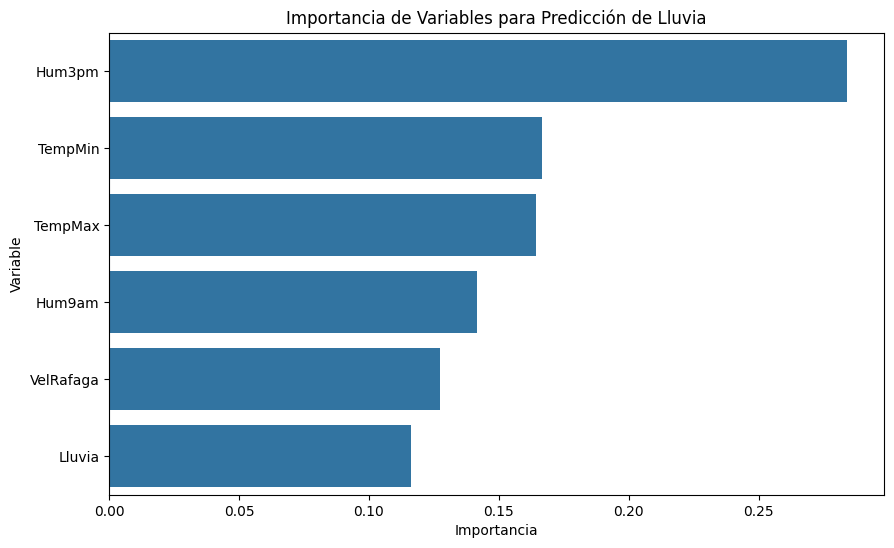

In [49]:
# Importancia de características
importancia = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': rf_model.feature_importances_
}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importancia, x='Importancia', y='Variable')
plt.title('Importancia de Variables para Predicción de Lluvia')
plt.show()

In [50]:
# 7. IMPLEMENTACIÓN Y EJEMPLO
print("\n=== 7. IMPLEMENTACIÓN Y EJEMPLO ===")
dia_ejemplo = {
    'TempMin': 15.0,
    'TempMax': 25.0,
    'Lluvia': 0.0,
    'VelRafaga': 35.0,
    'Hum9am': 65.0,
    'Hum3pm': 45.0
}

ejemplo_scaled = scaler.transform(pd.DataFrame([dia_ejemplo]))
prediccion = rf_model.predict_proba(ejemplo_scaled)

print("\nPredicción para día ejemplo:")
print(f"Probabilidad de lluvia para mañana: {prediccion[0][1]:.2%}")


=== 7. IMPLEMENTACIÓN Y EJEMPLO ===

Predicción para día ejemplo:
Probabilidad de lluvia para mañana: 3.00%


In [51]:
# 8. DOCUMENTACIÓN DE INSIGHTS
print("\n=== 8. INSIGHTS Y RECOMENDACIONES ===")
print("1. Patrones estacionales:")
print("   - Se identifican claras variaciones de temperatura por mes")
print("   - La lluvia muestra patrones específicos por ubicación")

print("\n2. Variables más influyentes:")
print(importancia.to_string(index=False))

print("\n3. Recomendaciones:")
print("   - Monitorear especialmente las variables de mayor importancia")
print("   - Considerar la ubicación geográfica en las predicciones")
print("   - Implementar sistema de alertas basado en probabilidades")


=== 8. INSIGHTS Y RECOMENDACIONES ===
1. Patrones estacionales:
   - Se identifican claras variaciones de temperatura por mes
   - La lluvia muestra patrones específicos por ubicación

2. Variables más influyentes:
 Variable  Importancia
   Hum3pm     0.284115
  TempMin     0.166691
  TempMax     0.164121
   Hum9am     0.141403
VelRafaga     0.127310
   Lluvia     0.116360

3. Recomendaciones:
   - Monitorear especialmente las variables de mayor importancia
   - Considerar la ubicación geográfica en las predicciones
   - Implementar sistema de alertas basado en probabilidades


In [52]:
# Guardar el modelo
# joblib.dump(rf_model, 'modelo_lluvia.joblib')
# print("\nModelo guardado como 'modelo_lluvia.joblib'")

In [53]:
# 9. DASHBOARD INTERACTIVO
print("\n=== 9. DASHBOARD INTERACTIVO ===")
print("Iniciando dashboard en http://localhost:8050")

app = dash.Dash(__name__)

# Layout del dashboard
app.layout = html.Div([
    html.H1('Dashboard Meteorológico de Australia', style={'textAlign': 'center'}),
    
    # Filtros superiores
    html.Div([
        html.Div([
            html.Label('Seleccionar Ubicación:'),
            dcc.Dropdown(
                id='ubicacion-dropdown',
                options=[{'label': loc, 'value': loc} for loc in df['Ubicacion'].unique()],
                value=df['Ubicacion'].unique()[0]
            )
        ], style={'width': '30%', 'display': 'inline-block'}),
        
        html.Div([
            html.Label('Rango de Fechas:'),
            dcc.DatePickerRange(
                id='date-picker',
                start_date=df['Fecha'].min(),
                end_date=df['Fecha'].max()
            )
        ], style={'width': '30%', 'display': 'inline-block'}),
    ]),
    
    # Visualizaciones
    html.Div([
        dcc.Graph(id='temp-time-series'),
        dcc.Graph(id='rain-probability'),
        dcc.Graph(id='humidity-correlation'),
        dcc.Graph(id='wind-rose')
    ]),
    
    # KPIs
    html.Div(id='kpi-cards')
])

@app.callback(
    [Output('temp-time-series', 'figure'),
     Output('rain-probability', 'figure'),
     Output('humidity-correlation', 'figure'),
     Output('wind-rose', 'figure'),
     Output('kpi-cards', 'children')],
    [Input('ubicacion-dropdown', 'value'),
     Input('date-picker', 'start_date'),
     Input('date-picker', 'end_date')]
)
def update_graphs(ubicacion, start_date, end_date):
    mask = (df['Ubicacion'] == ubicacion) & \
           (df['Fecha'] >= start_date) & \
           (df['Fecha'] <= end_date)
    filtered_df = df[mask]
    
    temp_fig = px.line(filtered_df, x='Fecha', y=['TempMin', 'TempMax'],
                       title='Temperaturas a lo largo del tiempo')
    
    rain_fig = px.histogram(filtered_df, x='Lluvia',
                           title='Distribución de Precipitaciones')
    
    humidity_fig = px.scatter(filtered_df, x='Hum9am', y='Hum3pm',
                             title='Correlación de Humedad (9am vs 3pm)')
    
    wind_fig = px.bar_polar(filtered_df, r='VelRafaga', theta='DirRafaga',
                           title='Rosa de los Vientos')
    
    kpi_cards = [
        html.Div([
            html.H4('Temperatura Media'),
            html.H2(f"{filtered_df['TempMax'].mean():.1f}°C")
        ]),
        html.Div([
            html.H4('Días con Lluvia'),
            html.H2(f"{(filtered_df['LluviaMan'] == 'Yes').sum()}")
        ]),
        html.Div([
            html.H4('Humedad Media'),
            html.H2(f"{filtered_df['Hum9am'].mean():.1f}%")
        ])
    ]
    
    return temp_fig, rain_fig, humidity_fig, wind_fig, kpi_cards

if __name__ == '__main__':
    app.run_server(debug=True)


=== 9. DASHBOARD INTERACTIVO ===
Iniciando dashboard en http://localhost:8050
